# 1. Graph Neural Network

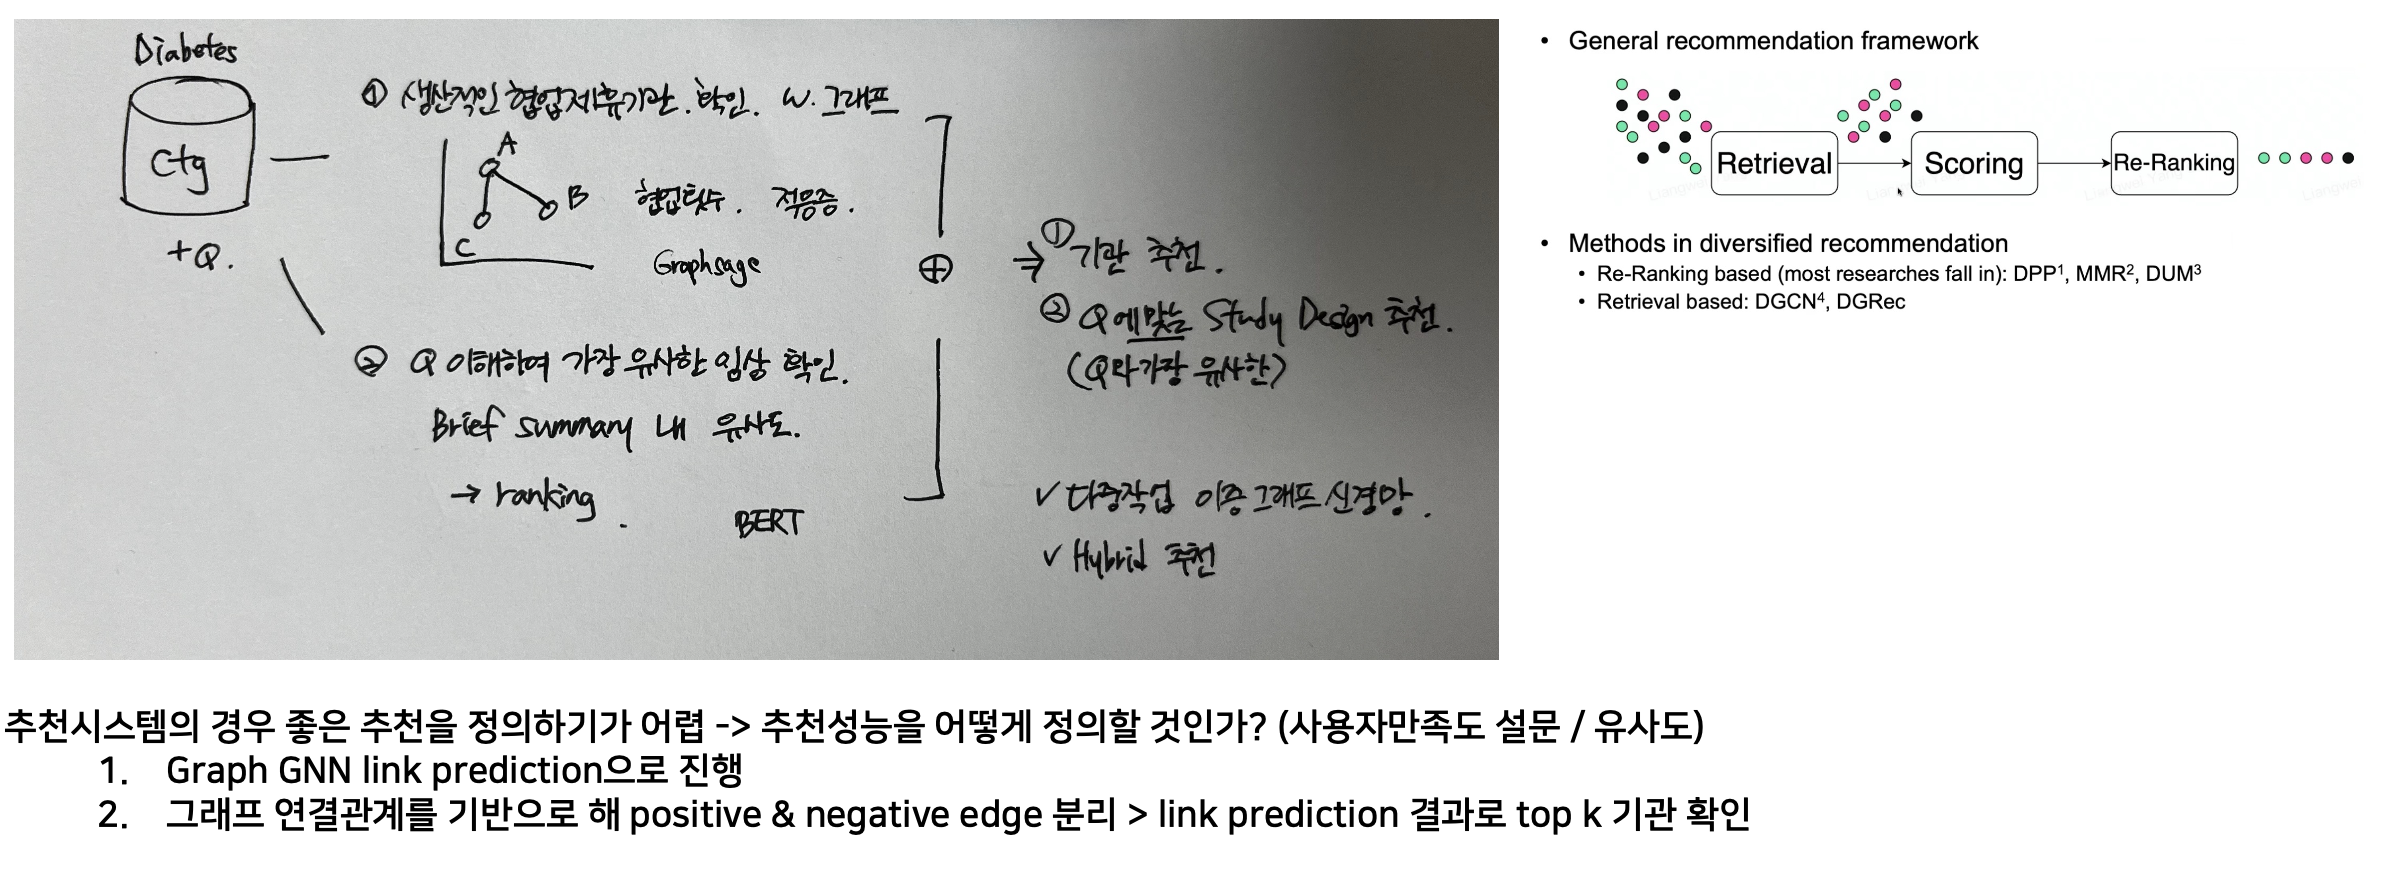

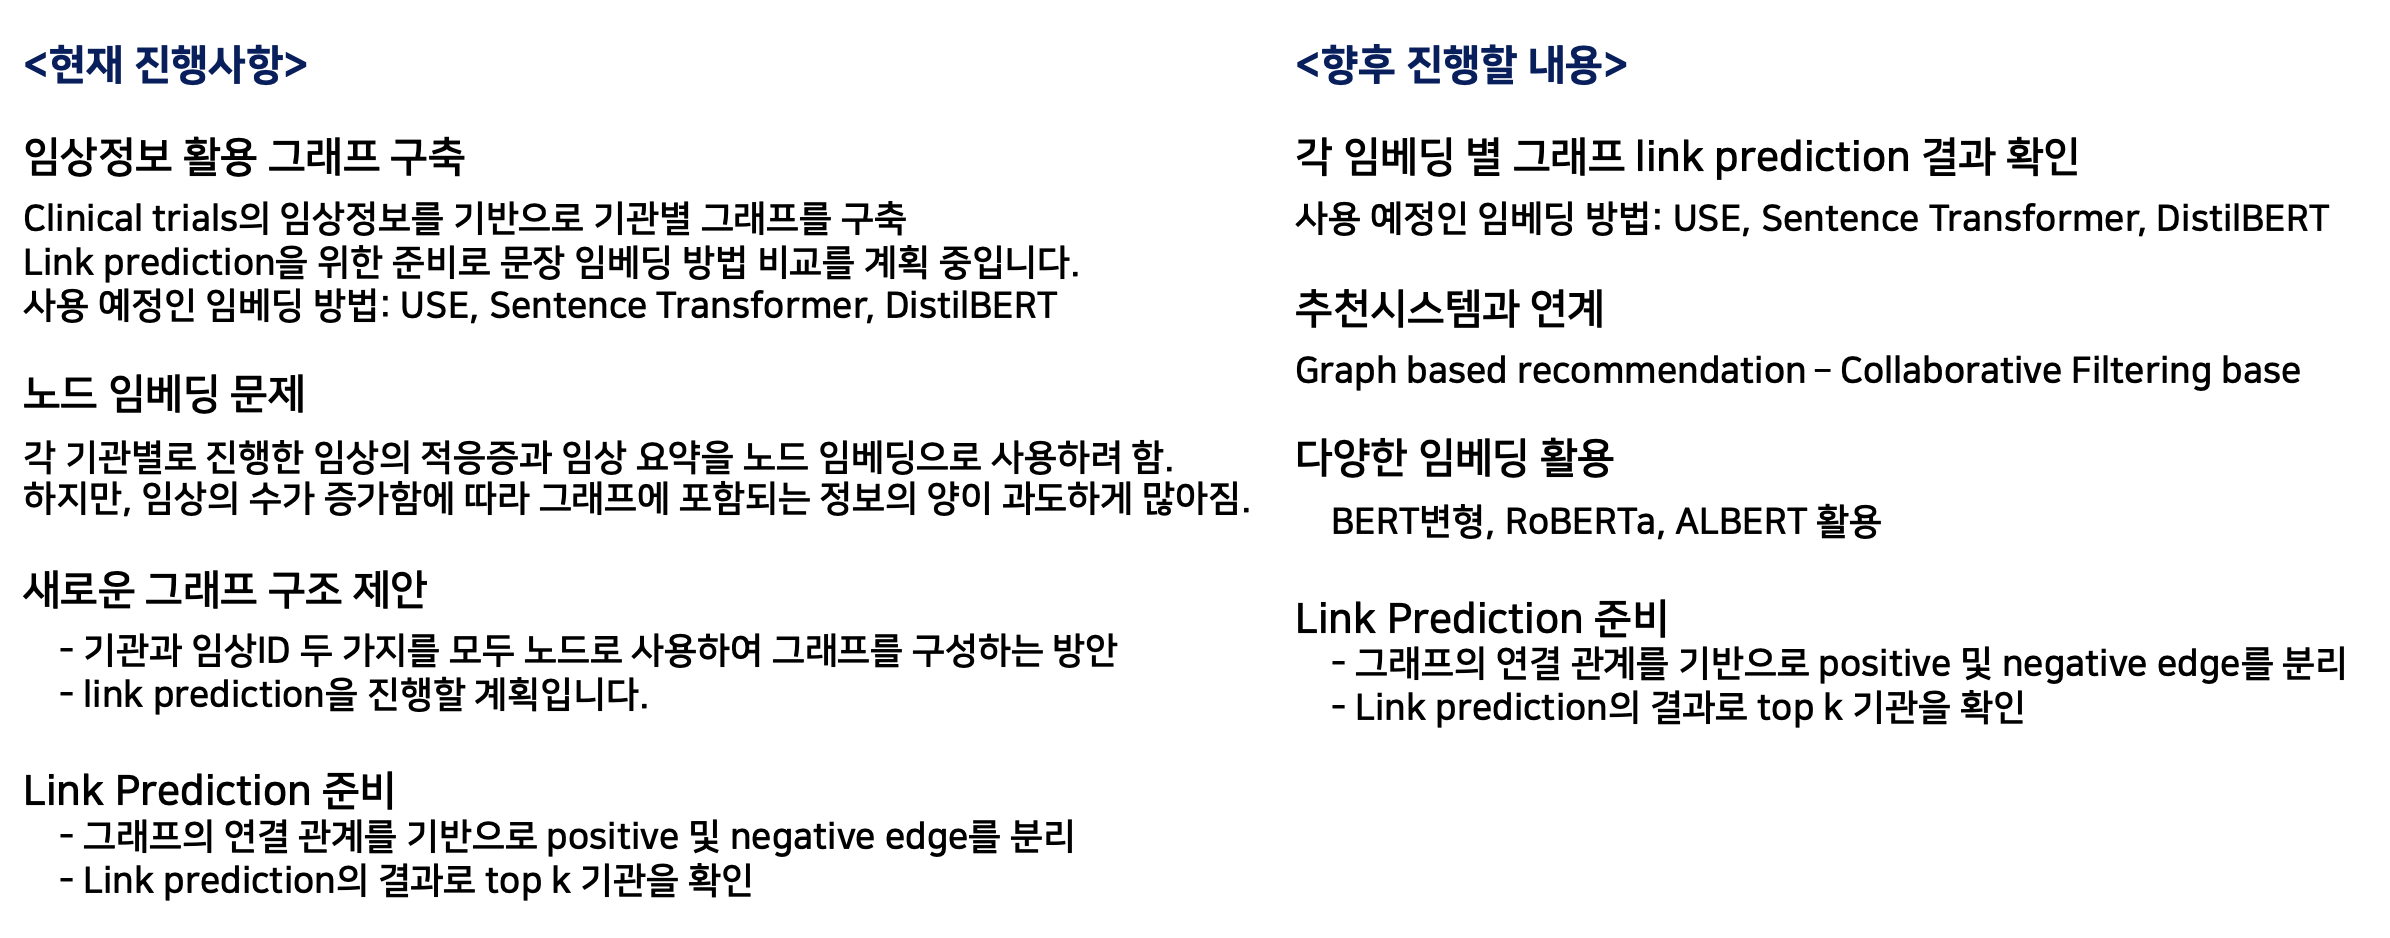

## 1.1 module import

In [ ]:
! pip install dgl
# ! pip install tqdm
# ! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.9 MB/s eta 0:00:00


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
from tqdm import tqdm
import pandas as pd
import networkx as nx
import scipy.sparse as sp

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## 1.2 Data import

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
from tqdm import tqdm
import pandas as pd
import networkx as nx
import scipy.sparse as sp

import os
os.environ['DGLBACKEND'] = 'pytorch'

path = 'ADD_YOUT_PATH'  # need to change

data = pd.read_csv(path+'Diabetes_embedding.csv')
def string_to_tensor(embedding_str):
    embedding_array = np.fromstring(embedding_str.strip('[]'), sep=' ')
    return torch.from_numpy(embedding_array)

data['embedding_tensor'] = data['embeddings_distilbert'].apply(string_to_tensor)

df_spon = pd.read_csv(path+'Diabetes_index_next_cnt_total.csv')


dict_spon = {}
for idx,row in tqdm(data.iterrows()):
    spon = row['affiliations']
    if spon is not np.nan:
        spon = spon.split('|')
        # times of research (each)
        temp = list(set(spon))
        for t in temp:
            if t is not np.nan:
                if t not in dict_spon.keys():
                    dict_spon[t]=1
                else:
                    dict_spon[t]+=1


display(df_spon.head(5))
df_spon['index'].shape

Mounted at /content/drive


13880it [00:02, 5569.70it/s]


index  \
0                 Boehringer Ingelheim   
1                          AstraZeneca   
2                          AstraZeneca   
3  National Institutes of Health (NIH)   
4                      Yale University   

                                                next  cnt  \
0                              Eli Lilly and Company   62   
1                               Bristol-Myers Squibb   50   
2                              Eli Lilly and Company   46   
3  National Institute of Diabetes and Digestive a...   43   
4  National Institute of Diabetes and Digestive a...   24   

                                           sentences  idxcnt  onecnt  
0  Diabetes Mellitus, Type 2 Primary objective: s...     145      62  
1  Type 2 Diabetes Mellitus This study will exami...     314     138  
2  Type 2 Diabetes Mellitus This study will exami...     314     138  
3  Obesity|Insulin Resistance|Type2 Diabetes The ...     132       0  
4  Hypo-unawareness|Type 1 Diabetes Mellitus Insu...      86      18

(19301,)

In [ ]:
from collections import defaultdict
affiliation_id = defaultdict(lambda:0)

for idx, u in enumerate((df_spon['index']+df_spon['next']).unique()):
    affiliation_id[u] = idx

df_spon['index_id'] = df_spon['index'].map(lambda x: affiliation_id[x])
df_spon['next_id'] = df_spon['next'].map(lambda x: affiliation_id[x])

temp = dgl.graph((df_spon['index_id'].to_numpy(), df_spon['next_id'].to_numpy()))
dgl.to_bidirected(temp)

Graph(num_nodes=1, num_edges=1,
      ndata_schemes={}
      edata_schemes={})

In [ ]:
data.drop(data.columns[15:],axis=1).to_csv('Diabetes.csv',index=False)
diabetes = data.drop(data.columns[15:],axis=1)
diabetes

NCT Number                                        Study Title  \
0      NCT05284071  Actiste® Diabetes Management as a Service (ADM...   
1      NCT05029271                              InPen User Experience   
2      NCT03976271  Consequences of Hypoglycaemia on Cardiovascula...   
3      NCT05560971  Monounsaturated Fatty Acid Supplementation for...   
4      NCT00462371  Comparison Between Insulin Pump Treatment and ...   
...            ...                                                ...   
13875  NCT00420095  A Study for Patients With Diabetes Mellitus (I...   
13876  NCT02774395  Endometrial Cancer and Fractalkine-receptor Ax...   
13877  NCT02961595       Live Enterovirus Vaccine and Type 1 Diabetes   
13878  NCT05308095                        The HEADWIND Study - Part 4   
13879  NCT02574195  Evolution of Effectiveness of Diabetes Medical...   

                                          Study URL Study Status  \
0      https://clinicaltrials.gov/study/NCT05284071    COMPLETED   
1      https://clinicaltrials.gov/study/NCT05029271   RECRUITING   
2      https://clinicaltrials.gov/study/NCT03976271    COMPLETED   
3      https://clinicaltrials.gov/study/NCT05560971   RECRUITING   
4      https://clinicaltrials.gov/study/NCT00462371    COMPLETED   
...                                             ...          ...   
13875  https://clinicaltrials.gov/study/NCT00420095    COMPLETED   
13876  https://clinicaltrials.gov/study/NCT02774395    COMPLETED   
13877  https://clinicaltrials.gov/study/NCT02961595    COMPLETED   
13878  https://clinicaltrials.gov/study/NCT05308095    COMPLETED   
13879  https://clinicaltrials.gov/study/NCT02574195    COMPLETED   

                                           Brief Summary  \
0      The overall aim of the clinical investigation ...   
1      The purpose of this study is to evaluate the u...   
2      People with Type 1 diabetes (T1DM), type 2 dia...   
3      The purpose of this study is to understand and...   
4      Comparison between insulin pump treatment and ...   
...                                                  ...   
13875  The purpose of this study is to compare glycem...   
13876  The endometrial cancers are among the most com...   
13877  Enterovirus infections may either increase or ...   
13878  To analyse driving behavior of individuals wit...   
13879  The main aim of the present study is to evalua...   

                                              Conditions  \
0                          Diabetes type1|Diabetes type2   
1                                        Diabetes Type 1   
2      Hypoglycemia|Inflammatory Response|Diabetes Me...   
3      PreDiabetes|Insulin Resistance|Overweight|Obesity   
4                        Diabetes Mellitus, Type 1|Child   
...                                                  ...   
13875  Diabetes Mellitus, Type 1|Diabetes Mellitus, T...   
13876                                 Endometrial Cancer   
13877  Enterovirus Infection|Type 1 Diabetes|Prediabe...   
13878                 Diabetes|Diabetes Mellitus, Type 1   
13879  Diabetes Mellitus, Type 2|Diabetes Mellitus, T...   

                                           Interventions  \
0      DEVICE: Device: Actiste 1.0 and the Companion ...   
1                   DEVICE: InPen with Guardian 4 System   
2      PROCEDURE: hyperinsulinemic normoglycaemic-hyp...   
3      DIETARY_SUPPLEMENT: Palmitoleic acid|OTHER: Pl...   
4                            DEVICE: Insulin pump (CSII)   
...                                                  ...   
13875  DRUG: Human insulin 30/70|DRUG: Insulin lispro...   
13876                                                NaN   
13877               BIOLOGICAL: Oral Polio Vaccine (OPV)   
13878  OTHER: Controlled hypoglycaemic state while dr...   
13879                                                NaN   

                                           Sponsor  \
0      Northern Care Alliance NHS Foundation Trust   
1                               Medtronic D

In [ ]:
import math

original = pd.read_csv(path+'Diabetes-clinical-studies.csv')
org = original[['Sponsor','Collaborators']]
caselist = org['Sponsor'].map(lambda x:x.split('|')) + org['Collaborators'].map(lambda x:x.split('|') if not pd.isna(x) else [])
ans,two,mv=0,0,0
for c in caselist:
    if len(c)==1:
        ans+=1
    if len(c)>2:
        two+=1
    if mv < len(c):
        mv = len(c)
        print(c)
print('1 node:',ans, 'more than 2:', two) # 8501 rows (put this node for the case nodes) | 1866 rows
print('total',len(caselist)) # 13880 rows
print('left', len(caselist)-ans) # 5379 rows (seperate under ratio 0.8 | 0.2 => math.floor())
print('maxvalue in list', mv)
# answer set

# caselist = sorted(caselist, key=lambda x:len(x))
train_size = ans + math.floor((len(caselist)-ans)*0.8)
test_size = len(caselist) - train_size
train,test = caselist[:train_size], caselist[train_size:]


# nodelist = {} # node - (edge, weight) | cnt
# train
from collections import defaultdict
train_cnt = defaultdict(lambda:0)

collaboration_counts = {}

for orglist in train:
    for org in orglist:
        train_cnt[org] += 1
        if org not in collaboration_counts:
            collaboration_counts[org] = {}

for orglist in train:
    for i in range(len(orglist)):
        for j in range(i+1, len(orglist)):
            org1 = orglist[i]
            org2 = orglist[j]
            if org2 not in collaboration_counts[org1]:
                collaboration_counts[org1][org2] = 0
            if org1 not in collaboration_counts[org2]:
                collaboration_counts[org2][org1] = 0
            collaboration_counts[org1][org2] += 1
            collaboration_counts[org2][org1] += 1

# collaboration_counts 딕셔너리는 각 유저(기관)가 어떤 기관과 몇 번 협업했는지 정보를 담고 있음

# test
from collections import defaultdict
test_cnt = defaultdict(lambda:0)

test_collaboration_counts = {}

for orglist in test:
    for org in orglist:
        test_cnt[org] += 1
        if org not in test_collaboration_counts:
            test_collaboration_counts[org] = {}

for orglist in test:
    for i in range(len(orglist)):
        for j in range(i+1, len(orglist)):
            org1 = orglist[i]
            org2 = orglist[j]
            if org2 not in test_collaboration_counts[org1]:
                test_collaboration_counts[org1][org2] = 0
            if org1 not in test_collaboration_counts[org2]:
                test_collaboration_counts[org2][org1] = 0
            test_collaboration_counts[org1][org2] += 1
            test_collaboration_counts[org2][org1] += 1


['Northern Care Alliance NHS Foundation Trust', 'Brighter AB']
['University of Leicester', 'University of Oxford', 'University of Manchester']
['Medstar Health Research Institute', 'Medstar Diabetes Institute;', 'American Diabetes Association', 'Bayer', 'CareFirst BlueCross Blue Shield;', 'District of Columbia, Department of Health Block Grants Program;', 'Charles and Mary Latham Trust Fund;', 'Eli Lilly and Company', 'Hewlett-Packard', 'Meltzer Entities;', 'NBC Washington', 'Novo Nordisk A/S', 'Aventis Pharmaceuticals', 'Takeda Pharmaceuticals North America, Inc.', 'Pfizer']
["King's College London", 'University of Southern Denmark', 'Sheffield Teaching Hospitals NHS Foundation Trust', 'Cambridge University Hospitals NHS Foundation Trust', 'Ninewells Hospital', 'Radboud University Medical Center', 'Nordsjaellands Hospital', 'Medical University of Graz', 'University Hospital, Montpellier', 'Innovative Medicines Initiative', 'The Leona M. and Harry B. Helmsley Charitable Trust', 'Juveni

In [ ]:
train.head(5), test.head(5)

(0    [Northern Care Alliance NHS Foundation Trust, ...
 1                                 [Medtronic Diabetes]
 2    [Radboud University Medical Center, Rigshospit...
 3    [Brigham and Women's Hospital, Tersus Life Sci...
 4         [Erasmus Medical Center, Ministry of Health]
 dtype: object,
 12804    [Attikon Hospital, Hellenic National Diabetes ...
 12805                             [Clalit Health Services]
 12806    [Pfizer's Upjohn has merged with Mylan to form...
 12807    [University of North Carolina, Chapel Hill, Zi...
 12808    [International Rescue Committee, Khon Kaen Uni...
 dtype: object)

In [ ]:
affiliation_id = {}
turn = 0
for orglist in caselist:
    for org in orglist:

        if org not in affiliation_id:
            affiliation_id[org] = turn
            turn+=1

# 전체 cnt 확인
totalcnt = defaultdict(lambda:0)
for orglist in caselist:
    for org in orglist:
        num = affiliation_id[org]
        totalcnt[num] += 1

# train에 edge는 안넣더라도 train을 위해서는 node개수 전체가 필요함
for k in affiliation_id.keys():
    if k not in train_cnt:
        train_cnt[k] = 0

print(len(affiliation_id),len(train_cnt))

6209 6209


In [ ]:
## Train
# nodes.csv (nid,cnt)
traindf = pd.DataFrame()
ii,kk,vv = [],[],[]
for k,v in train_cnt.items():
    ii.append(affiliation_id[k])
    kk.append(k)
    vv.append(train_cnt[k])
traindf['nid'] = ii
traindf['cnt'] = vv
traindf['nname'] = kk
traindf.to_csv(path+'Diabetes_traindf_wname.csv',index=False)
traindf.drop(['nname'],axis=1).to_csv(path+'Diabetes_nodes.csv',index=False)
train_nodes = traindf.drop(['nname'],axis=1)
display(train_nodes)

# edges.csv (src,dst,weight)
import csv
with open(path+'Diabetes_edges.csv', 'w', newline='') as csvfile:
    fieldnames = ['src', 'dst', 'weight']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for k, v in collaboration_counts.items():
        src = affiliation_id[k]
        for _k, _v in v.items():
            dst = affiliation_id[_k]
            weight = _v
            writer.writerow({'src': src, 'dst': dst, 'weight': weight})
train_edges = pd.read_csv(path+'Diabetes_edges.csv')
display(train_edges)

## Test
# nodes.csv (nid,cnt)
# affiliation_id = {}
testdf = pd.DataFrame()
ii,kk,vv = [],[],[]
for k,v in test_cnt.items():
    # affiliation_id[k] = idx
    ii.append(affiliation_id[k])
    kk.append(k)
    vv.append(test_cnt[k])
testdf['nid'] = ii
testdf['cnt'] = vv
testdf['nname'] = kk
testdf.to_csv(path+'Diabetes_testdf_wname.csv',index=False)
testdf.drop(['nname'],axis=1).to_csv(path+'Diabetes_nodes_test.csv',index=False)
test_nodes = testdf.drop(['nname'],axis=1)
display(test_nodes)

# edges.csv (src,dst,weight)
# test_node and affiliation check

import csv
with open(path+'Diabetes_edges_test.csv', 'w', newline='') as csvfile:
    fieldnames = ['src', 'dst', 'weight']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for k, v in test_collaboration_counts.items():
        src = affiliation_id[k]
        for _k, _v in v.items():
            dst = affiliation_id[_k]
            weight = _v
            writer.writerow({'src': src, 'dst': dst, 'weight': weight})
test_edges = pd.read_csv(path+'Diabetes_edges_test.csv')
display(test_edges)

nid  cnt
0        0    2
1        1    1
2        2   33
3        3   32
4        4   44
...    ...  ...
6204  6204    0
6205  6205    0
6206  6206    0
6207  6207    0
6208  6208    0

[6209 rows x 2 columns]

src   dst  weight
0         0     1       1
1         0    21       1
2         0    20       1
3         0   541       1
4         1     0       1
...     ...   ...     ...
34601  5889   670       1
34602  5890  2814       1
34603  5890  5889       1
34604  5890   814       1
34605  5890   670       1

[34606 rows x 3 columns]

nid  cnt
0     5694    1
1     5891    1
2      579    2
3     1293    1
4      601    7
...    ...  ...
1013  6208    1
1014  2384    1
1015  2944    1
1016   301    1
1017  1085    1

[1018 rows x 2 columns]

src   dst  weight
0     5694  5891       1
1     5891  5694       1
2      579   573       1
3      601  5892       1
4      601    13       1
...    ...   ...     ...
3603  6208  1180       1
3604  2944   176       1
3605  2944   301       1
3606   301   176       1
3607   301  2944       1

[3608 rows x 3 columns]

In [ ]:
import dgl
src, dst = train_edges['src'].to_numpy(), train_edges['dst'].to_numpy()

train_g = dgl.graph((src,dst))
num_isolated_nodes = 6209 - train_g.number_of_nodes()
train_g.add_nodes(num_isolated_nodes)

print('#Nodes', train_g.number_of_nodes())
print('#Edges', train_g.number_of_edges())

import torch
import torch.nn.functional as F

# Prepare the age node feature
train_nodes['cnt'] = train_nodes['cnt']/10
# cnt = torch.tensor(train_nodes['cnt'].to_numpy()).float()
train_g.ndata['cnt'] = torch.tensor(train_nodes['cnt'].values).float().unsqueeze(1)

edge_weight = torch.tensor(train_edges['weight'].values).float().unsqueeze(1)
train_g.edata['weight'] = edge_weight
# totalG.edata['weight'] = torch.tensor(edge_data['weight'].values).float().unsqueeze(1)

print('[ TRAIN ]\n',train_g)
print()

test_src, test_dst = test_edges['src'].to_numpy(), test_edges['dst'].to_numpy()

test_g = dgl.graph((test_src,test_dst))
# test_g.ndata['nid'] = torch.tensor(test_no des['nid'])

print('#Nodes', test_g.number_of_nodes())
print('#Edges', test_g.number_of_edges())

import torch
import torch.nn.functional as F

# cnt = torch.tensor(test_nodes['cnt'].to_numpy()).float() / 10
# test_g.ndata['cnt'] = cnt

edge_weight = torch.tensor(test_edges['weight'].values).float().unsqueeze(1)
test_g.edata['weight'] = edge_weight

print('[ TEST ]\n',test_g)

#Nodes 6209
#Edges 34606
[ TRAIN ]
 Graph(num_nodes=6209, num_edges=34606,
      ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})

#Nodes 6209
#Edges 3608
[ TEST ]
 Graph(num_nodes=6209, num_edges=3608,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})


In [ ]:
totalcntlist = []
for n in test_g.nodes().numpy():
    totalcntlist.append(totalcnt[n]/10)
test_g.ndata['cnt'] = torch.tensor(totalcntlist).float().unsqueeze(1)
test_g

Graph(num_nodes=6209, num_edges=3608,
      ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})

In [ ]:
# train pos/neg
train_neg_u,train_neg_v = dgl.sampling.global_uniform_negative_sampling(train_g, train_g.number_of_edges())
train_neg_u,train_neg_v
train_pos_g = train_g
train_neg_g = dgl.graph((train_neg_u,train_neg_v), num_nodes=train_g.number_of_nodes())

# test pos/neg
test_neg_u,test_neg_v = dgl.sampling.global_uniform_negative_sampling(test_g, test_g.number_of_edges())
test_pos_g = test_g
test_neg_g = dgl.graph((test_neg_u,test_neg_v), num_nodes=test_g.number_of_nodes())


In [ ]:
# 초기화용
affiliation_to_id = affiliation_id

train_pos_g, train_neg_g, test_pos_g, test_neg_g

(Graph(num_nodes=6209, num_edges=34606,
       ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
       edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=6209, num_edges=34606,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=6209, num_edges=3608,
       ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
       edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=6209, num_edges=3608,
       ndata_schemes={}
       edata_schemes={}))

In [ ]:
len(df_spon['index'].unique()), len(df_spon['next'].unique())
# index - next 차이!
# index,next 로는 네트워크 그래프 만들고, trial별로 (A,B,C,?) ?를 맞추는 방향으로 짜기

A, B = df_spon['index'], df_spon['next']
# 컬럼 'A'와 'B'의 교집합
intersection = set(A).intersection(B)

# 컬럼 'A'의 값 중에서 'B'에는 없는 값들 (A - B)
difference_A_B = set(A).difference(B)

# 컬럼 'B'의 값 중에서 'A'에는 없는 값들 (B - A)
difference_B_A = set(B).difference(A)

print('A, B:', len(A), len(B))
print("교집합:", len(intersection), intersection)
print("A - B 차집합:", len(difference_A_B), difference_A_B)
print("B - A 차집합:", len(difference_B_A) ,difference_B_A)

uspon = set(A).union(set(B))
len(uspon)

A, B: 19301 19301
교집합: 2534 {"Children's Hospital Medical Center, Cincinnati", 'Nutrisystem, Inc.', 'Fred Hutchinson Cancer Center', 'Italian Society of Diabetology', 'Canadian Institutes of Health Research (CIHR)', 'Fundação de Amparo à Pesquisa do estado de Minas Gerais', 'University of Dundee', 'NYU Grossman School of Medicine', 'Diana Food, Symrise', 'The Gothenburg Society of Medicine', 'University of Passau', 'Syracuse University', 'Departamento de Promoção da Saúde (DEPROS), Secretaria de Atenção Primária à Saúde (SAPS)', "Kula No Na Po'e Hawaii", 'Federal University of Rio Grande do Sul', 'Danish Council for Independent Research', 'AdventHealth Diabetes Institute', 'Provincial Health Services Authority', 'Supreme Council Of Health, Qatar', 'French Development Agency', 'Sheffield Hallam University', "Guy's and St Thomas' NHS Foundation Trust", 'North West London Collaboration of CCGs (NWL CCGs)', 'University of Cadiz', 'Aspetar', 'Helse Vest', 'Clinical Directors Network', 'Mayo

5058

## plotly

In [ ]:
import plotly.express as px
conditions_split = diabetes['Normalized'].str.split('[|]', expand=True).stack().str.strip()

# 각 조건별로 개수 세기
condition_counts = conditions_split.value_counts()

condition_counts.iloc[3] = 2465
condition_counts.drop('Diabetes',inplace=True)

# For Conditions
fig_conditions = px.bar(condition_counts, x=condition_counts.index[:10], y=condition_counts.values[:10],
                        labels={'x':'Condition', 'y':'Count'}, title='Counts of Each Condition')

# Checking if 'norm_study' exists in the dataframe and creating the plot for intervention types
if 'norm_study' in diabetes.columns:
    intervention_counts = diabetes['norm_study'].str.split('|').explode().value_counts()
    fig_interventions = px.bar(intervention_counts, x=intervention_counts.index, y=intervention_counts.values, color_discrete_sequence =['green']*12,
                               labels={'x':'Intervention Type', 'y':'Count'}, title='Counts of Each Intervention Type')
else:
    fig_interventions = None

# fig_conditions, fig_interventions if fig_interventions else "Intervention data not available."

fig_conditions.show()
fig_interventions.show()

## 1.3 No use
- dict_spon.keys() to numeric data
- NCT number+embeddingtensor | affiliation+cnt,nct number list? | edge: trial participate institution

In [ ]:
# NCT Number unique 확인
if data['NCT Number'].dtype == 'object':
    data['NCT Number'] = data['NCT Number'].str.replace('NCT','')
    data['NCT Number'] = data['NCT Number'].astype(int)

print(len(data['NCT Number']),len(data['NCT Number'].unique()))

# affiliation별 임상 체크
d = data[['NCT Number','affiliations']]
nct = []
rows = []
for idx,row in d.iterrows():
    for aff in row['affiliations'].split('|'):
        nct.append(row['NCT Number'])
        rows.append(aff)
aff_df = pd.DataFrame({
    'NCT Number':nct,
    'affiliations':rows,
})
affiliation_to_trials = aff_df.groupby('affiliations')['NCT Number'].apply(list).to_dict()
# pd.DataFrame({
#     'affiliation':list(affiliation_to_trials.keys()),
#     'trials':list(affiliation_to_trials.values()),
# })

# 노드 데이터 처리1
nodes_data = data[['NCT Number','embedding_tensor']]
nodes_data.rename(columns={'NCT Number':'node_id'}, inplace=True)

# 노드 데이터 처리2
nodes_data2 = pd.DataFrame({
    'affiliation': list(dict_spon.keys()),
    'cnt': list(dict_spon.values())
})
# nct number - node id 매핑
nct_to_dgl_id = {nct: nid for nid, nct in enumerate(nodes_data['node_id'])}
nodes_data['node_id'] = nodes_data['node_id'].map(nct_to_dgl_id)
aff_df['node_id'] = aff_df['NCT Number'].map(nct_to_dgl_id)

# affiliation을 숫자 ID로 매핑
affiliation_to_id = {aff: idx for idx, aff in enumerate(nodes_data2['affiliation'].unique())}
nodes_data2['affiliation_id'] = nodes_data2['affiliation'].map(affiliation_to_id)

merged = aff_df.merge(nodes_data,how='left')
merged['node_id'] = merged['NCT Number'].map(nct_to_dgl_id)
merged['affiliation_id'] = merged['affiliations'].map(affiliation_to_id)
aff_df = merged
aff_df

13880 13880


<ipython-input-57-e85a162c3c47>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_data.rename(columns={'NCT Number':'node_id'}, inplace=True)
<ipython-input-57-e85a162c3c47>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_data['node_id'] = nodes_data['node_id'].map(nct_to_dgl_id)


NCT Number                                 affiliations  node_id  \
0         5284071  Northern Care Alliance NHS Foundation Trust        0   
1         5284071                                  Brighter AB        0   
2         5029271                           Medtronic Diabetes        1   
3         3976271            Radboud University Medical Center        2   
4         3976271                      Rigshospitalet, Denmark        2   
...           ...                                          ...      ...   
23644     2961595                           Tampere University    13877   
23645     5308095    Insel Gruppe AG, University Hospital Bern    13878   
23646     5308095        Swiss Federal Institute of Technology    13878   
23647     5308095                      University of St.Gallen    13878   
23648     2574195        Endocrinology Research Centre, Moscow    13879   

                                        embedding_tensor  affiliation_id  
0      [tensor(-0.4794, dtype=torch.float64), tensor(...               0  
1      [tensor(-0.4794, dtype=torch.float64), tensor(...               1  
2      [tensor(-0.3433, dtype=torch.float64), tensor(...               2  
3      [tensor(-0.1486, dtype=torch.float64), tensor(...               4  
4      [tensor(-0.1486, dtype=torch.float64), tensor(...               3  
...                                                  ...             ...  
23644  [tensor(-0.1714, dtype=torch.float64), tensor(...            2384  
23645  [tensor(-0.2771, dtype=torch.float64), tensor(...             177  
23646  [tensor(-0.2771, dtype=torch.float64), tensor(...            2944  
23647  [tensor(-0.2771, dtype=torch.float64), tensor(...             300  
23648  [tensor(-0.2094, dtype=torch.float64), tensor(...            1085  

[23649 rows x 5 columns]

In [ ]:
# 엣지 데이터 처리
edge_data = df_spon[['index','next','cnt']]
edge_data.rename(columns={'index':'source', 'next':'target', 'cnt':'weight'}, inplace=True)
edge_data['source'] = edge_data['source'].map(affiliation_to_id)
edge_data['target'] = edge_data['target'].map(affiliation_to_id)

# trial과 institution 사이의 엣지 데이터 생성

# Heterograph 생성
# 노드 생성
# NCT Number를 trial로, affiliation을 institution
g = dgl.heterograph({
    ('trial','participate','institution'):(aff_df['node_id'].values, aff_df['affiliation_id'].values),
    ('institution', 'collaborate', 'institution'): (edge_data['source'].values, edge_data['target'].values)
})

# 노드 특성 추가
g.nodes['trial'].data['embedding'] = torch.stack(nodes_data['embedding_tensor'].tolist())
g.nodes['institution'].data['cnt'] = torch.tensor(nodes_data2['cnt'].values).float().unsqueeze(1)

# 엣지 특성 추가
g.edges['collaborate'].data['weight'] = torch.tensor(edge_data['weight'].values).float().unsqueeze(1)



<ipython-input-58-7947809d16b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_data.rename(columns={'index':'source', 'next':'target', 'cnt':'weight'}, inplace=True)
<ipython-input-58-7947809d16b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_data['source'] = edge_data['source'].map(affiliation_to_id)
<ipython-input-58-7947809d16b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
totalG = dgl.graph((edge_data['source'].values, edge_data['target'].values))
totalG.ndata['cnt'] = torch.tensor(nodes_data2['cnt'].values).float().unsqueeze(1)
totalG

Graph(num_nodes=6209, num_edges=19301,
      ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
# 40개의 노드를 무작위로 선택합니다.
selected_nodes_trial = np.random.choice(g.nodes('institution').numpy(), size=40, replace=False)

# 이 노드들과 연결된 institution 노드를 찾습니다.
related_nodes_institution = []
for node in selected_nodes_trial:
    related_nodes_institution.extend(g.successors(node, etype=('institution', 'collaborate', 'institution')).numpy())
related_nodes_institution = np.unique(related_nodes_institution)  # 중복 제거

# 선택된 노드를 기반으로 부분 그래프를 생성합니다.
sub_g = g.subgraph({
    'trial': selected_nodes_trial,
    'institution': related_nodes_institution
})


# 서브그래프에서 모든 간선을 가져옵니다.
all_edges = sub_g.edges(etype=('institution', 'collaborate', 'institution'))

# 간선을 무작위로 섞습니다.
num_edges = len(all_edges[0])
permuted_edges = np.random.permutation(num_edges)

# 간선을 훈련, 검증, 테스트 세트로 분할합니다.
train_size = int(0.8 * num_edges)
valid_size = int(0.1 * num_edges)
train_eids = permuted_edges[:train_size]
valid_eids = permuted_edges[train_size:train_size+valid_size]
test_eids = permuted_edges[train_size+valid_size:]

# 결과를 확인합니다.
print("Number of training edges:", len(train_eids))
print("Number of validation edges:", len(valid_eids))
print("Number of test edges:", len(test_eids))



Number of training edges: 138
Number of validation edges: 17
Number of test edges: 18


In [ ]:

# 학습 그래프를 생성합니다. 검증 및 테스트 간선을 제거합니다.
train_eids_tensor = torch.tensor(train_eids, dtype=torch.long)
train_g = sub_g.edge_subgraph({
    ('institution', 'collaborate', 'institution'): train_eids
})

# 검증 그래프를 생성합니다. 학습 및 테스트 간선을 제거합니다.
val_g = sub_g.edge_subgraph({
    ('institution', 'collaborate', 'institution'): list(valid_eids)
})

# 테스트 그래프를 생성합니다. 학습 및 검증 간선을 제거합니다.
test_g = sub_g.edge_subgraph({
    ('institution', 'collaborate', 'institution'): list(test_eids)
})


In [ ]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class HeteroGraphSAGELinkPredict(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()

        # Define the HeteroGraphConv module
        self.conv = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_features, hidden_features)
            for rel in rel_names}, aggregate='sum')

        self.W = nn.Linear(hidden_features * 2, out_features)

    def forward(self, graph, inputs):
        # Inputs are features of nodes
        h = self.conv(graph, inputs)
        with graph.local_scope():
            graph.ndata['h'] = h
            # Compute pairwise dot product as the score
            graph.apply_edges(lambda edges: {'score': (edges.src['h'] * edges.dst['h']).sum(-1)})
            return graph.edata['score']

# Assume g is the heterograph created before
model = HeteroGraphSAGELinkPredict(10, 20, 1, g.etypes)


In [ ]:
print(sub_g)

Graph(num_nodes={'institution': 78, 'trial': 40},
      num_edges={('institution', 'collaborate', 'institution'): 173, ('trial', 'participate', 'institution'): 13},
      metagraph=[('institution', 'institution', 'collaborate'), ('trial', 'institution', 'participate')])


In [ ]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F

# Graph 분할
# eids = np.arange(sub_g.number_of_edges())
# eids = np.random.permutation(eids)
# train_eids = eids[:int(len(eids) * 0.8)]
# valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
# test_eids = eids[int(len(eids) * 0.9):]
# # train_g = g.edge_subgraph(train_eids, preserve_nodes=True)
# train_g = g.edge_subgraph(train_eids)
# valid_g = g.edge_subgraph(valid_eids)
# test_g = g.edge_subgraph(test_eids)



# 그래프 신경망 모델 정의
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = dgl.nn.SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = dgl.nn.SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Link Prediction Loss 계산 함수
def compute_loss(pos_score, neg_score):
    # Positive links의 loss
    pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones_like(pos_score))

    # Negative links의 loss
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros_like(neg_score))

    return pos_loss + neg_loss

# 모델 및 학습 파라미터 초기화
institution_feats = sub_g.nodes['institution'].data['cnt']
trial_feats = sub_g.nodes['trial'].data['embedding']
node_features = {'institution': institution_feats, 'trial': trial_feats}
model = GraphSAGE(node_features['institution'].shape[1], 16, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

# 학습 루프
for epoch in range(100):
    model.train()
    logits = model(train_g, institution_feats)

    # Link Prediction: Positive samples
    pos_score = torch.sigmoid((logits[train_g.edges()[0]] * logits[train_g.edges()[1]]).sum(dim=1))

    # Link Prediction: Negative samples (랜덤하게 선택)
    neg_score = torch.sigmoid((logits[train_g.edges()[0]] * logits[torch.randint(0, g.number_of_nodes(), (train_g.number_of_edges(),))]).sum(dim=1))

    # Loss 계산
    loss = compute_loss(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# 추론 및 평가 (Validation Set)
model.eval()
with torch.no_grad():
    # Forward Pass
    logits = model(val_g, institution_feats)

    # Link Prediction: Positive samples
    pos_score_val = torch.sigmoid((logits[g.edges()[0][valid_eids]] * logits[g.edges()[1][valid_eids]]).sum(dim=1))

    # Link Prediction: Negative samples (랜덤하게 선택)
    neg_score_val = torch.sigmoid((logits[g.edges()[0][valid_eids]] * logits[torch.randint(0, g.number_of_nodes(), (len(valid_eids),))]).sum(dim=1))

    # Loss 계산
    val_loss = compute_loss(pos_score_val, neg_score_val)
    print(f"Validation Loss: {val_loss.item()}")


AssertionError: ignored

In [ ]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F

# sub_g를 기반으로 학습, 검증 및 테스트 그래프를 생성합니다.
eids = np.arange(sub_g.number_of_edges())
eids = np.random.permutation(eids)
train_eids = eids[:int(len(eids) * 0.8)]
valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
test_eids = eids[int(len(eids) * 0.9):]

train_g = sub_g.edge_subgraph(train_eids)
valid_g = sub_g.edge_subgraph(valid_eids)
test_g = sub_g.edge_subgraph(test_eids)

# 그래프 신경망 모델 정의
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = dgl.nn.SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = dgl.nn.SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Link Prediction Loss 계산 함수
def compute_loss(pos_score, neg_score):
    pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones_like(pos_score))
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros_like(neg_score))
    return pos_loss + neg_loss

# 모델 및 학습 파라미터 초기화
node_features = {'institution': sub_g.nodes['institution'].data['cnt'],
                 'trial': sub_g.nodes['trial'].data['embedding']}
model = GraphSAGE(train_g.num_node_features('institution'), 16, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

# 학습 루프
for epoch in range(100):
    model.train()
    logits = model(train_g, node_features['institution'])

    pos_score = torch.sigmoid((logits[train_g.edges()[0]] * logits[train_g.edges()[1]]).sum(dim=1))

    # Negative sampling (랜덤하게 선택)
    neg_score = torch.sigmoid((logits[train_g.edges()[0]] * logits[torch.randint(0, sub_g.number_of_nodes(), (train_g.number_of_edges(),))]).sum(dim=1))

    loss = compute_loss(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# 추론 및 평가 (Validation Set)
model.eval()
with torch.no_grad():
    logits = model(valid_g, node_features['institution'])
    pos_score_val = torch.sigmoid((logits[valid_g.edges()[0]] * logits[valid_g.edges()[1]]).sum(dim=1))
    neg_score_val = torch.sigmoid((logits[valid_g.edges()[0]] * logits[torch.randint(0, sub_g.number_of_nodes(), (len(valid_eids),))]).sum(dim=1))
    val_loss = compute_loss(pos_score_val, neg_score_val)
    print(f"Validation Loss: {val_loss.item()}")


# !! GraphSAGE

In [ ]:
totalG = dgl.graph((edge_data['source'].values,edge_data['target'].values))
totalG.ndata['cnt'] = torch.tensor(nodes_data2['cnt'].values).float().unsqueeze(1)
totalG.edata['weight'] = torch.tensor(edge_data['weight'].values).float().unsqueeze(1)

g = totalG

## 1. Data Construction

In [ ]:
def remove_isolated_nodes(g):
    """
    Remove isolated nodes from a given DGL graph and return a new graph.
    """
    # Get degrees for each node
    degrees = g.in_degrees()

    # Find nodes which have non-zero degrees (i.e., they are connected)
    non_isolated_nodes = torch.nonzero(degrees > 0).squeeze()

    # Create subgraph with only non-isolated nodes
    sub_g = g.subgraph(non_isolated_nodes)

    # Map the node data from the original graph to the new subgraph
    for key, value in g.ndata.items():
        sub_g.ndata[key] = value[non_isolated_nodes]

    return sub_g

# Example usage:
g_cleaned = remove_isolated_nodes(g)
print(g)
print(g_cleaned)


In [ ]:
### test ###
def split_edges(g, test_node_ratio=0.2):
    nodes = np.arange(g.number_of_nodes())
    np.random.shuffle(nodes)

    test_nodes_size = int(len(nodes) * test_node_ratio)
    test_nodes = nodes[:test_nodes_size]
    train_nodes = nodes[test_nodes_size:]

    # Create a mask for edges to be moved to test set
    edge_src, edge_dst = g.edges()
    test_edge_mask = np.isin(edge_src.numpy(), test_nodes) | np.isin(edge_dst.numpy(), test_nodes)
    train_edge_mask = ~test_edge_mask

    test_src, test_dst = edge_src[test_edge_mask], edge_dst[test_edge_mask]
    train_src, train_dst = edge_src[train_edge_mask], edge_dst[train_edge_mask]

    test_g = dgl.graph((test_src, test_dst), num_nodes=g.number_of_nodes())
    train_g = dgl.graph((train_src, train_dst), num_nodes=g.number_of_nodes())

    # Copy node data
    for key, value in g.ndata.items():
        train_g.ndata[key] = value  # Here we're copying all node data to both train and test graphs
        test_g.ndata[key] = value   # If you only want a subset, modify this as needed

    # Copy edge data (only for the edges that exist in each respective graph)
    for key, value in g.edata.items():
        train_g.edata[key] = value[train_edge_mask]
        test_g.edata[key] = value[test_edge_mask]

    return train_g, test_g

train_g, test_g = split_edges(g)

# 1) allow_zero_in_degree =True | 2) add self loop
train_g = dgl.add_self_loop(train_g)
test_g = dgl.add_self_loop(test_g)

print(train_g,'\n',test_g)

Graph(num_nodes=6209, num_edges=18281,
      ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)}) 
 Graph(num_nodes=6209, num_edges=13438,
      ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})


In [ ]:
# test with pos,neg sampling

def split_edges_with_negatives(g, test_node_ratio=0.2):
    def sample_negative_edges(pos_g, num_neg_samples):
        pos_u, pos_v = pos_g.edges()
        neg_u, neg_v = [], []

        while len(neg_u) < num_neg_samples:
            u = np.random.choice(g.number_of_nodes())
            v = np.random.choice(g.number_of_nodes())

            if u == v or g.has_edges_between(u, v) or g.has_edges_between(v, u):
                continue
            neg_u.append(u)
            neg_v.append(v)

        return np.array(neg_u), np.array(neg_v)

    train_g, test_g = split_edges(g, test_node_ratio)

    # maybe the node 0 is the issue
    train_g = dgl.add_self_loop(train_g)
    test_g = dgl.add_self_loop(test_g)

    train_pos_u, train_pos_v = train_g.edges()
    train_neg_u, train_neg_v = sample_negative_edges(train_g, train_g.number_of_edges())

    test_pos_u, test_pos_v = test_g.edges()
    test_neg_u, test_neg_v = sample_negative_edges(test_g, test_g.number_of_edges())

    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

    # Create a mask for edges to be moved to test set
    train_nodes = train_g.nodes()
    test_nodes = test_g.nodes()
    edge_src, edge_dst = g.edges()
    test_edge_mask = np.isin(edge_src.numpy(), test_nodes) | np.isin(edge_dst.numpy(), test_nodes)
    train_edge_mask = ~test_edge_mask

    # Transfer node data
    for key, value in g.ndata.items():
        train_g.ndata[key] = value
        test_g.ndata[key] = value
        train_pos_g.ndata[key] = value
        test_pos_g.ndata[key] = value
        train_neg_g.ndata[key] = value
        test_neg_g.ndata[key] = value

    # Transfer edge data
    for key, value in g.edata.items():
        train_g.edata[key] = value[train_g.edges()]
        test_g.edata[key] = value[test_g.edges()]
        train_pos_g.edata[key] = value[train_pos_g.edges()]
        test_pos_g.edata[key] = value[test_pos_g.edges()]
        train_neg_g.edata[key] = value[train_neg_g.edges()]
        test_neg_g.edata[key] = value[test_neg_g.edges()]

    return train_g, test_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g

# Example usage:
train_g, test_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = split_edges_with_negatives(g)

print(train_g,'\n',test_g)


In [ ]:
train_g.edata

{'weight': tensor([[62.],
        [50.],
        [46.],
        ...,
        [ 1.],
        [ 1.],
        [ 1.]])}

In [ ]:
=# train_pos, train_neg, test_pos, test_neg node 다 6209임

In [ ]:
print(train_pos_g,'\n',train_neg_g)

Graph(num_nodes=6209, num_edges=18725,
      ndata_schemes={}
      edata_schemes={}) 
 Graph(num_nodes=6209, num_edges=18725,
      ndata_schemes={}
      edata_schemes={})


In [ ]:
# IT"S ORIGINALLL
TEST_RATIO = 0.3  # ratio for splitting the test set

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
train_size = g.number_of_edges() - test_size  # number of edges in train set

# get positive edges for test and train
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges
num_nodes = g.number_of_nodes()
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(num_nodes,num_nodes))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the negative edges for training and testing
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# construct positive and negative graphs for training and testing
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# training graph
train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)

In [ ]:
test_pos_g

Graph(num_nodes=6209, num_edges=3608,
      ndata_schemes={'cnt': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})

## 2. Model Construction

In [ ]:
from dgl.nn import SAGEConv
from dgl.nn import GraphConv
from dgl.nn import GINConv
from dgl.nn import GATConv

# ----------- create model -------------- #
# build an ordinary GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# drop 제거
class GAT(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GAT, self).__init__()
        # self.conv1 = GATConv(in_feats, h_feats, num_heads=8, feat_drop=0.6, attn_drop=0.6, activation=F.relu)
        # self.conv2 = GATConv(8 * h_feats, h_feats, num_heads=1, feat_drop=0.6, attn_drop=0.6)
        self.conv1 = GATConv(in_feats, h_feats, num_heads=8, activation=F.relu)
        self.conv2 = GATConv(8 * h_feats, h_feats, num_heads=1)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat).flatten(1)
        h = self.conv2(g, h).squeeze(1)
        return h

class GIN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GIN, self).__init__()
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(in_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, h_feats)
        ))
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, h_feats)
        ))

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = self.conv2(g, h)
        return h

import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


In [ ]:
from sklearn.metrics import roc_auc_score

def pipeline(model_name='GCN', hidden_size=16):
    best_auc = 0.5  # 초기 AUC 기준값 설정
    patience = 50  # 연속해서 AUC가 향상되지 않는 에폭 수
    counter = 0  # AUC가 향상되지 않는 에폭 수 카운터

    # model_name can be GCN or SAGE
    # hidden_size is the size of the hidden layer in the neural net
    if model_name == 'GCN':
        model = GCN(train_g.ndata['cnt'].shape[1], hidden_size)
    elif model_name == 'SAGE':
        model = GraphSAGE(train_g.ndata['cnt'].shape[1], hidden_size)
    elif model_name == 'GAT':
        model = GAT(train_g.ndata['cnt'].shape[1], hidden_size)
    elif model_name == 'GIN':
        model = GIN(train_g.ndata['cnt'].shape[1], hidden_size)

    pred = DotPredictor()

    def compute_loss(pos_score, neg_score):  # computes the loss based on binary cross entropy
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

    def compute_auc(pos_score, neg_score):  # computes AUC (Area-Under-Curve) score
        scores = torch.cat([pos_score, neg_score]).numpy()
        labels = torch.cat(
            [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        return roc_auc_score(labels, scores)

    from sklearn.metrics import precision_recall_fscore_support

    def compute_f1(pos_score, neg_score, threshold=0.5):
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        # Apply the threshold to the scores to get binary predictions
        preds = (scores > threshold).float()
        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), preds.numpy(), average='binary')
        return f1

    # ----------- set up loss and optimizer -------------- #
    # in this case, loss will in training loop
    # optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01) # 기존 0.001 / lr 줄이기
    optimizer = torch.optim.RMSprop(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)  # , weight_decay=0.01

    # ----------- training -------------------------------- #
    all_logits = []
    for e in range(1500):
        # forward
        h = model(train_g, train_g.ndata['cnt'])  # get node embeddings
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print('In epoch {}, loss: {}'.format(e, loss))

    # ----------- test and check results ---------------- #
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))
        f1 = compute_f1(pos_score, neg_score)
        print('F1 Score', f1)

    return h  # return node embeddings


### Training and testing GCN

In [ ]:
train_g.ndata['cnt'].shape[1]

train_g = dgl.add_self_loop(train_g)
test_g = dgl.add_self_loop(test_g)

In [ ]:
model_gcn = pipeline("GCN")

In epoch 0, loss: 0.5875113606452942
In epoch 10, loss: 0.5694875121116638
In epoch 20, loss: 0.5649039149284363
In epoch 30, loss: 0.564355194568634
In epoch 40, loss: 0.5625349879264832
In epoch 50, loss: 0.5612695217132568
In epoch 60, loss: 0.559642493724823
In epoch 70, loss: 0.5571126937866211
In epoch 80, loss: 0.5556321144104004
In epoch 90, loss: 0.5522590279579163
In epoch 100, loss: 0.5499093532562256
In epoch 110, loss: 0.5462998747825623
In epoch 120, loss: 0.5430746078491211
In epoch 130, loss: 0.5400741696357727
In epoch 140, loss: 0.5378018021583557
In epoch 150, loss: 0.5359662771224976
In epoch 160, loss: 0.5341901183128357
In epoch 170, loss: 0.5324470400810242
In epoch 180, loss: 0.5310043692588806
In epoch 190, loss: 0.5297660827636719
In epoch 200, loss: 0.5285733342170715
In epoch 210, loss: 0.5276750922203064
In epoch 220, loss: 0.5268063545227051
In epoch 230, loss: 0.5260664820671082
In epoch 240, loss: 0.5255165696144104
In epoch 250, loss: 0.5249564051628113

### Training and testing SAGE

In [ ]:
model_sage = pipeline("SAGE")

In epoch 0, loss: 20.43427276611328
In epoch 10, loss: 0.7400223612785339
In epoch 20, loss: 0.6381431818008423
In epoch 30, loss: 0.6050277352333069
In epoch 40, loss: 0.5866187214851379
In epoch 50, loss: 0.5741183161735535
In epoch 60, loss: 0.5647612810134888
In epoch 70, loss: 0.5572025179862976
In epoch 80, loss: 0.5509576797485352
In epoch 90, loss: 0.5456075072288513
In epoch 100, loss: 0.5408417582511902
In epoch 110, loss: 0.5367287397384644
In epoch 120, loss: 0.5332838296890259
In epoch 130, loss: 0.5302372574806213
In epoch 140, loss: 0.5276023745536804
In epoch 150, loss: 0.5256018042564392
In epoch 160, loss: 0.5238561630249023
In epoch 170, loss: 0.5222803950309753
In epoch 180, loss: 0.5208256840705872
In epoch 190, loss: 0.5199461579322815
In epoch 200, loss: 0.5193191766738892
In epoch 210, loss: 0.519324541091919
In epoch 220, loss: 0.5198031663894653
In epoch 230, loss: 0.5199234485626221
In epoch 240, loss: 0.5202492475509644
In epoch 250, loss: 0.5194624662399292

In [ ]:
'''
[GCN]
AUC 0.7146727707828379
F1 Score 0.7209266409266409
[SAGE]
AUC 0.7085332667980984
F1 Score 0.6865295845572807
'''

### Training and testing GAT

In [ ]:
model_gat = pipeline("GAT")

In epoch 0, loss: 3.9455955028533936
In epoch 10, loss: 0.5992754101753235
In epoch 20, loss: 0.5962688326835632
In epoch 30, loss: 0.5938887596130371
In epoch 40, loss: 0.5910775065422058
In epoch 50, loss: 0.5882238149642944
In epoch 60, loss: 0.5844078660011292
In epoch 70, loss: 0.5803422331809998
In epoch 80, loss: 0.5759506225585938
In epoch 90, loss: 0.5714171528816223
In epoch 100, loss: 0.5674310922622681
In epoch 110, loss: 0.5645697712898254
In epoch 120, loss: 0.5613632798194885
In epoch 130, loss: 0.5587626099586487
In epoch 140, loss: 0.5561610460281372
In epoch 150, loss: 0.5533245801925659
In epoch 160, loss: 0.5513731837272644
In epoch 170, loss: 0.5499111413955688
In epoch 180, loss: 0.5486018657684326
In epoch 190, loss: 0.5473015308380127
In epoch 200, loss: 0.5463138818740845
In epoch 210, loss: 0.5459573864936829
In epoch 220, loss: 0.5463191270828247
In epoch 230, loss: 0.5448766946792603
In epoch 240, loss: 0.5452266931533813
In epoch 250, loss: 0.54632627964019

### Training and testing GIN

In [ ]:
model_gin = pipeline("GIN")

In epoch 0, loss: 14957.0849609375
In epoch 10, loss: 0.7106318473815918
In epoch 20, loss: 0.7103591561317444
In epoch 30, loss: 0.710080623626709
In epoch 40, loss: 0.7097946405410767
In epoch 50, loss: 0.7095026969909668
In epoch 60, loss: 0.7092044949531555
In epoch 70, loss: 0.7089008092880249
In epoch 80, loss: 0.7085907459259033
In epoch 90, loss: 0.708276093006134
In epoch 100, loss: 0.7079558372497559
In epoch 110, loss: 0.7076306939125061
In epoch 120, loss: 0.7073010206222534
In epoch 130, loss: 0.7069680690765381
In epoch 140, loss: 0.7066305875778198
In epoch 150, loss: 0.7062904834747314
In epoch 160, loss: 0.7059471607208252
In epoch 170, loss: 0.7056018710136414
In epoch 180, loss: 0.7052547931671143
In epoch 190, loss: 0.7049062252044678
In epoch 200, loss: 0.7045574188232422
In epoch 210, loss: 0.7042077779769897
In epoch 220, loss: 0.7038587927818298
In epoch 230, loss: 0.703510582447052
In epoch 240, loss: 0.7031636238098145
In epoch 250, loss: 0.7028188109397888
In

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# loss 줄때까지 더 돌려보기 ()


### Friend Recommendation

In [ ]:
# --------- generate recommendation for user -------- #
num_nodes = train_g.number_of_nodes()

def generate_rec(h, user_id=0):
    # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

    # generate a graph with (num_nodes - num_friends_of_user) edges
    # one end of the edge is user_id
    # the other end is a user that's NOT friends with user_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # get all friends of user_id
        if int(n1) == user_id:
            user_friends.add(int(n2))
        if int(n2) == user_id:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # generate "negative edges" for user_id
        if i != user_id and i not in user_friends:
            user_neg_u.append(user_id)
            user_neg_v.append(i)

    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=train_g.number_of_nodes())

    pred = DotPredictor()

    # calculate the score of each user
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    aff = next((k for k,v in affiliation_to_id.items() if v == user_id),None)
    print(f"List of 5 suggested affiliations for aff {user_id} ({aff}):")
    # ans = []
    for i in range(5):
        aff = next((k for k,v in affiliation_to_id.items() if v == scores[i][0]),None)
        print(f'- Affiliation {scores[i][0]} {aff}, score = {scores[i][1]}')
    return scores


In [ ]:
s = generate_rec(model_gcn, user_id=4)
s[0][0], s[0][1]

List of 5 suggested affiliations for aff 4 (Rigshospitalet, Denmark):
- Affiliation 12 University of Oklahoma, score = 51.96733093261719
- Affiliation 143 The Center for Clinical and Translational Sciences (CCTS) Clinical Research Unit at The University of Texas Health Science Center at Houston, score = 32.36005401611328
- Affiliation 23 University College, London, score = 30.197179794311523
- Affiliation 10 Yale University, score = 29.555992126464844
- Affiliation 26 Lexicon Pharmaceuticals, score = 24.7097110748291


(12, tensor(51.9673, grad_fn=<UnbindBackward0>))

In [ ]:
yale = generate_rec(model_gcn, user_id=10)
astra = generate_rec(model_gcn, user_id=144)
samsung = generate_rec(model_gcn, user_id=116)
nih = generate_rec(model_gcn, user_id=82)
pfizer = generate_rec(model_gcn, user_id=49)

List of 5 suggested affiliations for aff 10 (Yale University):
- Affiliation 12 University of Oklahoma, score = 70.38641357421875
- Affiliation 23 University College, London, score = 49.082801818847656
- Affiliation 42 Charles and Mary Latham Trust Fund;, score = 36.86526107788086
- Affiliation 143 The Center for Clinical and Translational Sciences (CCTS) Clinical Research Unit at The University of Texas Health Science Center at Houston, score = 36.58577346801758
- Affiliation 26 Lexicon Pharmaceuticals, score = 34.381282806396484
List of 5 suggested affiliations for aff 144 (AstraZeneca):
- Affiliation 13 National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK), score = 123.14030456542969
- Affiliation 24 Novo Nordisk A/S, score = 80.36663055419922
- Affiliation 11 Juvenile Diabetes Research Foundation, score = 61.43980407714844
- Affiliation 43 Eli Lilly and Company, score = 60.04574966430664
- Affiliation 27 Sanofi, score = 59.54380798339844
List of 5 suggested affil

In [ ]:
# aff 10 (Yale University):
# - Affiliation 12 University of Oklahoma, score = 70.38641357421875
# - Affiliation 23 University College, London, score = 49.082801818847656
# - Affiliation 42 Charles and Mary Latham Trust Fund;, score = 36.86526107788086
# - Affiliation 143 The Center for Clinical and Translational Sciences (CCTS) Clinical Research Unit at The University of Texas Health Science Center at Houston, score = 36.58577346801758
# - Affiliation 26 Lexicon Pharmaceuticals, score = 34.381282806396484

# aff 144 (AstraZeneca):
# - Affiliation 13 National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK), score = 123.14030456542969
# - Affiliation 24 Novo Nordisk A/S, score = 80.36663055419922
# - Affiliation 11 Juvenile Diabetes Research Foundation, score = 61.43980407714844
# - Affiliation 43 Eli Lilly and Company, score = 60.04574966430664
# - Affiliation 27 Sanofi, score = 59.54380798339844

# aff 116 (Samsung Medical Center):
# - Affiliation 278 Diamyd Medical AB, score = 6.971492767333984
# - Affiliation 52 Canadian Institutes of Health Research (CIHR), score = 6.694347381591797
# - Affiliation 62 University of Copenhagen, score = 6.25277042388916
# - Affiliation 1162 Prof. Amir Tirosh, score = 6.18956184387207
# - Affiliation 421 Université Montpellier, score = 5.138236999511719

# aff 82 (National Institutes of Health (NIH)):
# - Affiliation 13 National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK), score = 106.25028228759766
# - Affiliation 24 Novo Nordisk A/S, score = 73.2659912109375
# - Affiliation 143 The Center for Clinical and Translational Sciences (CCTS) Clinical Research Unit at The University of Texas Health Science Center at Houston, score = 55.99247741699219
# - Affiliation 43 Eli Lilly and Company, score = 54.988983154296875
# - Affiliation 27 Sanofi, score = 51.80897521972656

In [ ]:
for i in affiliation_id.keys():
    if 'pfizer' in i.lower():
        print(i)

Pfizer
Pfizer's Upjohn has merged with Mylan to form Viatris Inc.
King Pharmaceuticals is now a wholly owned subsidiary of Pfizer
Wyeth is now a wholly owned subsidiary of Pfizer
Array Biopharma, now a wholly owned subsidiary of Pfizer


In [ ]:
affiliation_id['Yale University'],affiliation_id['AstraZeneca'],affiliation_id['Samsung Medical Center'],affiliation_id['National Institutes of Health (NIH)'],affiliation_id['Pfizer']

(10, 144, 116, 82, 49)

In [ ]:
# # check check
# test_edges_uniq = test_edges.src.unique()
# test_edge_ans = defaultdict(lambda:0)

# revdict = {v:k for k,v in affiliation_id.items()}
# for idx,temp in test_edges.iterrows():
#     src,dst,weight = temp
#     if src in test_edge_ans:
#         continue
#     aff = next((k for k,v in affiliation_to_id.items() if v == src),None)
#     print(f'--------src:{aff} >> {dst}:{revdict[dst]},{weight}--------')
#     # 아래 generate_rec에서 리스트 뽑아내야할듯
#     scores = generate_rec(model_sage, user_id=src)
#     test_edge_ans[src] = scores[0]

# test_edge_ans

# # for src in test_g.head(10)['source']:
# #     aff = next((k for k,v in affiliation_to_id.items() if v == src),None)
# #     print('--------'+aff+'--------')
# #     generate_rec(model_sage, user_id=src)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
- Affiliation 144 AstraZeneca, score = 1.0216702222824097
- Affiliation 27 Sanofi, score = 0.8673108816146851
--------src:Fondation ARC >> 302:Assistance Publique - Hôpitaux de Paris,1--------
List of 5 suggested affiliations for aff 5896 (Fondation ARC):
- Affiliation 1095 Diabetes Care Center, score = 0.6033861637115479
- Affiliation 5891 Hellenic National Diabetes Center, score = 0.48965486884117126
- Affiliation 5892 Zimmer Dental, score = 0.48965486884117126
- Affiliation 5893 International Rescue Committee, score = 0.48965486884117126
- Affiliation 5894 St Vincent's Institute of Medical Research, score = 0.48965486884117126
--------src:University of Aarhus >> 62:University of Copenhagen,1--------
List of 5 suggested affiliations for aff 61 (University of Aarhus):
- Affiliation 24 Novo Nordisk A/S, score = 818.6054077148438
- Affiliation 13 National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK), score = 789.8565673828125
- Affi

defaultdict(<function __main__.<lambda>()>,
            {5694: (29, tensor(0.4809, grad_fn=<UnbindBackward0>)),
             5891: (1095, tensor(0.6034, grad_fn=<UnbindBackward0>)),
             579: (572, tensor(1.2798, grad_fn=<UnbindBackward0>)),
             601: (24, tensor(113.5158, grad_fn=<UnbindBackward0>)),
             5892: (1095, tensor(0.6034, grad_fn=<UnbindBackward0>)),
             5893: (1095, tensor(0.6034, grad_fn=<UnbindBackward0>)),
             4023: (29, tensor(0.4809, grad_fn=<UnbindBackward0>)),
             910: (24, tensor(296.5031, grad_fn=<UnbindBackward0>)),
             43: (24, tensor(4191.8560, grad_fn=<UnbindBackward0>)),
             1841: (198, tensor(2.9109, grad_fn=<UnbindBackward0>)),
             295: (24, tensor(243.3240, grad_fn=<UnbindBackward0>)),
             349: (24, tensor(29.5870, grad_fn=<UnbindBackward0>)),
             52: (24, tensor(619.4989, grad_fn=<UnbindBackward0>)),
             5: (23, tensor(302.7445, grad_fn=<UnbindBackward

### test for new recall, precision

- Recall@K (Recall at K): Recall은 실제 정답 중에서 모델이 얼마나 많이 예측한 것인지를 측정하는 메트릭입니다. Recall@K은 상위 K개의 추천 항목 중에서 실제 정답에 포함된 항목의 비율을 나타냅니다. 예를 들어, Recall@1은 상위 1개의 추천 항목 중에서 실제 정답에 포함된 항목의 비율을 나타냅니다.

- Precision@K: Precision은 모델이 상위 K개의 추천 항목 중에서 실제 정답 항목의 비율을 나타내는 메트릭입니다. Precision@K은 상위 K개의 추천 항목 중에서 실제 정답에 포함된 항목의 비율을 나타냅니다.

In [ ]:
# model_sage[[0,1]]

tensor([[ 0.0390, -0.0689,  0.1180,  0.1024,  0.2136,  0.0316, -0.1017, -0.0608,
          0.2448, -0.1897, -0.1494,  0.0488, -0.1318, -0.8396,  0.0738,  0.1240],
        [-0.1298, -0.1741, -0.0297,  0.0759,  0.3606,  0.0599, -0.0091,  0.1477,
         -0.2002, -0.2035,  0.0288, -0.0729, -0.1591, -0.3389,  0.1235, -0.1509]],
       grad_fn=<IndexBackward0>)

In [ ]:
# # --------- generate recommendation for user -------- #
# num_nodes = train_g.number_of_nodes()

# def generate_rec(h, user_id):
#     # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

#     # generate a graph with (num_nodes - num_friends_of_user) edges
#     # one end of the edge is user_id
#     # the other end is a user that's NOT friends with user_id
#     user_friends = set()
#     user_neg_u, user_neg_v = [], []
#     for n1, n2 in zip(u, v):   # get all friends of user_id
#         if int(n1) == user_id:
#             user_friends.add(int(n2))
#         if int(n2) == user_id:
#             user_friends.add(int(n1))

#     for i in range(num_nodes):  # generate "negative edges" for user_id (for this part, not neg/just check connection)
#         if i != user_id:
#             user_neg_u.append(user_id)
#             user_neg_v.append(i)

#     user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=train_g.number_of_nodes())

#     pred = DotPredictor()

#     # calculate the score of each user
#     scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

#     # produce final ranked list
#     scores.sort(key=lambda x: -x[1])

#     # display results
#     aff = next((k for k,v in affiliation_to_id.items() if v == user_id),None)
#     print(f"List of 5 suggested affiliations for aff {user_id} ({aff}):")
#     # ans = []
#     # for i in range(5):
#     #     aff = next((k for k,v in affiliation_to_id.items() if v == scores[i][0]),None)
#     #     print(f'- Affiliation {scores[i][0]} {aff}, score = {scores[i][1]}')
#     return scores


In [ ]:
# test 23.10.23
######
from math import log
import random

K=10
revdict = {v:k for k,v in affiliation_id.items()}

test_user_id = {}
precision = []
recall = []
f1_score = []
ndcg_score = []
rnode = []
rans = []
anslist = []
anslist_gat = []
anslist_gcn = []

for idx, row in enumerate(test):
    if len(row) < 2:
        # anslist.append([])
        continue
    else:
        ans = random.randint(0, len(row)-1)
        ansnode = row[ans]
        row.remove(ansnode)
        rans.append(ansnode)
        rnode.append(row)
        # print(row)

        scores = []
        test_score = defaultdict(lambda:0)
        test_score_gat = defaultdict(lambda:0)
        test_score_gcn = defaultdict(lambda:0)

        for idx, user_name in enumerate(row):
            user_id = affiliation_id[user_name]
            # print(user_id)
            # SAGE
            score = generate_rec(model_sage, user_id)
            for sc in score:
                # 정규화?
                test_score[sc[0]] += torch.detach(sc[1]).numpy()
            # GAT
            score_gat = generate_rec(model_gat, user_id)
            for sc in score_gat:
                # 정규화?
                test_score_gat[sc[0]] += torch.detach(sc[1]).numpy()
            # GCN
            score_gcn = generate_rec(model_gcn, user_id)
            for sc in score_gcn:
                # 정규화?
                test_score_gcn[sc[0]] += torch.detach(sc[1]).numpy()

        test_score = dict(sorted(test_score.items(), key=lambda item: item[1], reverse=True))
        test_score_gat = dict(sorted(test_score_gat.items(), key=lambda item: item[1], reverse=True))
        test_score_gcn = dict(sorted(test_score_gcn.items(), key=lambda item: item[1], reverse=True))

        # SAGE
        tempans = list(test_score.keys())[:K]
        tempans = [revdict[j] for j in tempans]
        anslist.append(tempans)
        # GAT
        tempans_gat = list(test_score_gat.keys())[:K]
        tempans_gat = [revdict[j] for j in tempans_gat]
        anslist_gat.append(tempans_gat)
        # GCN
        tempans_gcn = list(test_score_gcn.keys())[:K]
        tempans_gcn = [revdict[j] for j in tempans_gcn]
        anslist_gcn.append(tempans_gcn)


# print(anslist)
testanscheck = pd.DataFrame()
testanscheck['rnode'] = rnode
testanscheck['rans'] = rans
testanscheck['SAGE_ans'] = anslist
testanscheck['GAT_ans'] = anslist_gat
testanscheck['GCN_ans'] = anslist_gcn

testanscheck

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
- Affiliation 27 Sanofi, score = 7.529876232147217
- Affiliation 93 Merck Sharp & Dohme LLC, score = 7.201345443725586
List of 5 suggested affiliations for aff 440 (Indiana University):
- Affiliation 640 Shenzhen Salubris Pharmaceuticals Co., Ltd., score = 34.88876724243164
- Affiliation 316 Sohag University, score = 15.469759941101074
- Affiliation 690 LipoScience, Inc., score = 12.396821975708008
- Affiliation 228 Federico II University, score = 10.360481262207031
- Affiliation 1258 Swedish Food Agency, score = 8.463113784790039
List of 5 suggested affiliations for aff 440 (Indiana University):
- Affiliation 13 National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK), score = 43.04452896118164
- Affiliation 24 Novo Nordisk A/S, score = 30.034433364868164
- Affiliation 43 Eli Lilly and Company, score = 22.50365447998047
- Affiliation 144 AstraZeneca, score = 22.164215087890625
- Affiliation 27 Sanofi, score = 21.028987884521484
List 

rnode  \
0                  [Hellenic National Diabetes Center]   
1          [University of North Carolina, Chapel Hill]   
2    [International Rescue Committee, Khon Kaen Uni...   
3         [University of Illinois at Urbana-Champaign]   
4                       [Mount Sinai Hospital, Canada]   
..                                                 ...   
411  [Centers for Disease Control and Prevention, A...   
412  [Hamad Medical Corporation, Weill Cornell Medi...   
413    [Blue Cross Blue Shield of Michigan Foundation]   
414         [Centre Hospitalier Universitaire de Nice]   
415  [Insel Gruppe AG, University Hospital Bern, Un...   

                                                  rans  \
0                                     Attikon Hospital   
1                                        Zimmer Dental   
2                             Johns Hopkins University   
3                    National Institute on Aging (NIA)   
4        Canadian Institutes of Health Research (CIHR)   
..                                                 ...   
411                  University of Southern California   
412        Weill Medical College of Cornell University   
413                           Henry Ford Health System   
414  Centre National de la Recherche Scientifique, ...   
415              Swiss Federal Institute of Technology   

                                              SAGE_ans  \
0    [Grace Hill Health Centers, Inc., The GCP unit...   
1    [Eli Lilly and Company, Sanofi, AstraZeneca, B...   
2    [Grace Hill Health Centers, Inc., The GCP unit...   
3    [Cairo University, Shanghai Jiao Tong Universi...   
4    [University of Geneva, Switzerland, Bristol-My...   
..                                                 ...   
411  [National Institute of Diabetes and Digestive ...   
412  [Cairo University, Vastra Gotaland Region, Uni...   
413  [Takeda, Bristol-Myers Squibb, DexCom, Inc., N...   
414  [Cairo University, Vastra Gotaland Region, Chi...   
415  [University of Aarhus, VA Office of Research a...   

                                               GAT_ans  \
0    [Hellenic National Diabetes Center, Zimmer Den...   
1    [Shenzhen Salubris Pharmaceuticals Co., Ltd., ...   
2    [Hellenic National Diabetes Center, Zimmer Den...   
3    [Assiut University, International Atomic Energ...   
4    [Shenzhen Salubris Pharmaceuticals Co., Ltd., ...   
..                                                 ...   
411  [Assiut University, Sohag University, Mitsubis...   
412  [University of Northern Colorado, Istanbul Phy...   
413  [Assiut University, Sohag University, National...   
414  [Federico II University, Biodel, Mitsubishi Ta...   
415  [Shenzhen Salubris Pharmaceuticals Co., Ltd., ...   

                                               GCN_ans  
0    [Hellenic National Diabetes Center, Zimmer Den...  
1    [National Institute of Diabetes and Digestive ...  
2    [Hellenic National Diabetes Center, Zimmer Den...  
3    [Karolinska Institutet, Imperial College Londo...  
4    [National Institute of Diabetes and Digestive ...  
..                                                 ...  
411  [National Institute of Diabetes and Digestive ...  
412  [Diamyd Medical AB, Canadian Institutes of Hea...  
413  [National Institute of Diabetes and Digestive ...  
414  [National Institute of Diabetes and Digestive ...  
415  [National Institute of Diabetes and Digestive ...  

[416 rows x 5 columns]

In [ ]:
# 결과를 저장할 빈 리스트 초기화
sage = []
gat = []
gcn = []

sage_score = 0
gat_score = 0
gcn_score = 0
# K개수
K = [i for i in range(10)]

# 각 테스트 데이터프레임에 대해 메트릭 계산
for k in K:
    for idx in range(len(testanscheck)):
        ans = testanscheck.iloc[idx]['rans']  # 실제 정답
        SAGE_ans = testanscheck.iloc[idx]['SAGE_ans']  # 모델의 예측값
        GAT_ans = testanscheck.iloc[idx]['GAT_ans']  # 모델의 예측값
        GCN_ans = testanscheck.iloc[idx]['GCN_ans']  # 모델의 예측값
        # print(SAGE_ans)
        if ans in SAGE_ans[k]:
            sage_score+=1
        if ans in GAT_ans[k]:
            gat_score+=1
        if ans in GCN_ans[k]:
            gcn_score+=1
    sage.append(sage_score)
    gat.append(gat_score)
    gcn.append(gcn_score)

# at10
print(f'GraphSAGE: {sage}\nGAT: {gat}\nGCN: {gcn}\n')

scores = pd.DataFrame()
scores['idx'] = [i for i in range(1,11)]
scores['sage'] = [i/(len(testanscheck)) for idx,i in enumerate(sage)]
scores['gat'] = [i/(len(testanscheck)) for idx,i in enumerate(gat)]
scores['gcn'] = [i/(len(testanscheck)) for idx,i in enumerate(gcn)]
scores

GraphSAGE: [3, 6, 9, 13, 15, 20, 22, 25, 27, 28]
GAT: [0, 1, 2, 3, 3, 5, 6, 8, 15, 19]
GCN: [17, 20, 25, 27, 33, 36, 37, 37, 41, 42]



idx      sage       gat       gcn
0    1  0.007212  0.000000  0.040865
1    2  0.014423  0.002404  0.048077
2    3  0.021635  0.004808  0.060096
3    4  0.031250  0.007212  0.064904
4    5  0.036058  0.007212  0.079327
5    6  0.048077  0.012019  0.086538
6    7  0.052885  0.014423  0.088942
7    8  0.060096  0.019231  0.088942
8    9  0.064904  0.036058  0.098558
9   10  0.067308  0.045673  0.100962

In [ ]:
# save scores
scores.to_csv('scores.csv',index=False)

In [ ]:
len(testanscheck)

416

In [ ]:
# 결과를 저장할 빈 리스트 초기화
sage_score = 0
gat_score = 0
gcn_score = 0

sage_score_1 = 0
gat_score_1 = 0
gcn_score_1 = 0

# 각 테스트 데이터프레임에 대해 메트릭 계산
for idx in range(len(testanscheck)):
    ans = testanscheck.iloc[idx]['rans']  # 실제 정답
    SAGE_ans = testanscheck.iloc[idx]['SAGE_ans']  # 모델의 예측값
    GAT_ans = testanscheck.iloc[idx]['GAT_ans']  # 모델의 예측값
    GCN_ans = testanscheck.iloc[idx]['GCN_ans']  # 모델의 예측값
    if ans in SAGE_ans:
        sage_score+=1
    if ans in GAT_ans:
        gat_score+=1
    if ans in GCN_ans:
        gcn_score+=1
    if ans == SAGE_ans[0]:
        sage_score_1 += 1
    if ans == GAT_ans[0]:
        gat_score_1 += 1
    if ans == GCN_ans[0]:
        gcn_score_1 += 1

# at10
print(sage_score,gat_score,gcn_score)
print(sage_score/len(testanscheck),gat_score/len(testanscheck),gcn_score/len(testanscheck))
# at1
print(sage_score_1,gat_score_1,gcn_score_1)
# at5
print(sage_score_1/len(testanscheck),gat_score_1/len(testanscheck),gcn_score_1/len(testanscheck))

# K개수(1~10), 어떻게 해야 개선될지

43 19 43
0.10336538461538461 0.04567307692307692 0.10336538461538461
0 0 15
0.0 0.0 0.036057692307692304


In [ ]:
# ONLY GCN
######
from math import log
import random

K=10
revdict = {v:k for k,v in affiliation_id.items()}

test_user_id = {}
precision = []
recall = []
rnode = []
rans = []
anslist_gcn = []

for idx, row in enumerate(test):
    if len(row) < 2:
        # anslist.append([])
        continue
    else:
        ans = random.randint(0, len(row)-1)
        ansnode = row[ans]
        row.remove(ansnode)
        rans.append(ansnode)
        rnode.append(row)
        # print(row)

        scores = []
        test_score = defaultdict(lambda:0)
        test_score_gat = defaultdict(lambda:0)
        test_score_gcn = defaultdict(lambda:0)

        for idx, user_name in enumerate(row):
            user_id = affiliation_id[user_name]
            # print(user_id)
            # GCN
            score_gcn = generate_rec(model_gcn, user_id)
            for sc in score_gcn:
                # 정규화?
                test_score_gcn[sc[0]] += torch.detach(sc[1]).numpy()

        test_score_gcn = dict(sorted(test_score_gcn.items(), key=lambda item: item[1], reverse=True))

        # GCN
        tempans_gcn = list(test_score_gcn.keys())[:K]
        tempans_gcn = [revdict[j] for j in tempans_gcn]
        anslist_gcn.append(tempans_gcn)


# print(anslist)
testanscheck = pd.DataFrame()
testanscheck['rnode'] = rnode
testanscheck['rans'] = rans
testanscheck['GCN_ans'] = anslist_gcn

testanscheck

List of 5 suggested affiliations for aff 5694 (Attikon Hospital):
- Affiliation 5890 La Caixa Foundation, score = 0.7282865047454834
- Affiliation 5891 Hellenic National Diabetes Center, score = 0.7282865047454834
- Affiliation 5892 Zimmer Dental, score = 0.7282865047454834
- Affiliation 5893 International Rescue Committee, score = 0.7282865047454834
- Affiliation 5894 St Vincent's Institute of Medical Research, score = 0.7282865047454834
List of 5 suggested affiliations for aff 601 (University of North Carolina, Chapel Hill):
- Affiliation 13 National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK), score = 39.366981506347656
- Affiliation 24 Novo Nordisk A/S, score = 24.971216201782227
- Affiliation 144 AstraZeneca, score = 22.629701614379883
- Affiliation 11 Juvenile Diabetes Research Foundation, score = 20.59568214416504
- Affiliation 27 Sanofi, score = 18.949853897094727
List of 5 suggested affiliations for aff 5893 (International Rescue Committee):
- Affiliation 5

rnode  \
0                                   [Attikon Hospital]   
1          [University of North Carolina, Chapel Hill]   
2    [International Rescue Committee, Johns Hopkins...   
3         [University of Illinois at Urbana-Champaign]   
4      [Canadian Institutes of Health Research (CIHR)]   
..                                                 ...   
411  [University of Southern California, Centers fo...   
412  [Weill Medical College of Cornell University, ...   
413                         [Henry Ford Health System]   
414  [Centre National de la Recherche Scientifique,...   
415  [Insel Gruppe AG, University Hospital Bern, Un...   

                                              rans  \
0                Hellenic National Diabetes Center   
1                                    Zimmer Dental   
2                             Khon Kaen University   
3                National Institute on Aging (NIA)   
4                     Mount Sinai Hospital, Canada   
..                                             ...   
411       Association of American Medical Colleges   
412         Weill Cornell Medical College in Qatar   
413  Blue Cross Blue Shield of Michigan Foundation   
414       Centre Hospitalier Universitaire de Nice   
415          Swiss Federal Institute of Technology   

                                               GCN_ans  
0    [La Caixa Foundation, Hellenic National Diabet...  
1    [National Institute of Diabetes and Digestive ...  
2    [National Institute of Diabetes and Digestive ...  
3    [Karolinska Institutet, Imperial College Londo...  
4    [National Institute of Diabetes and Digestive ...  
..                                                 ...  
411  [National Institute of Diabetes and Digestive ...  
412  [National Institute of Diabetes and Digestive ...  
413  [National Institute of Diabetes and Digestive ...  
414  [Hellenic National Diabetes Center, Zimmer Den...  
415  [National Institute of Diabetes and Digestive ...  

[416 rows x 3 columns]

In [ ]:
# 결과를 저장할 빈 리스트 초기화
gcn = []

gcn_score = 0
# K개수
K = [i for i in range(10)]

# 각 테스트 데이터프레임에 대해 메트릭 계산
for k in K:
    for idx in range(len(testanscheck)):
        ans = testanscheck.iloc[idx]['rans']  # 실제 정답
        GCN_ans = testanscheck.iloc[idx]['GCN_ans']  # 모델의 예측값
        # print(SAGE_ans
        if ans in GCN_ans[k]:
            gcn_score+=1
    gcn.append(gcn_score)

# at10
# print(f'GraphSAGE: {sage}\nGAT: {gat}\nGCN: {gcn}\n')
# print(f'GAT: {gat}')

scores = pd.DataFrame()
scores['idx'] = [i for i in range(1,11)]
scores['gcn'] = [i/(len(testanscheck)) for idx,i in enumerate(gcn)]
scores

idx       gcn
0    1  0.057692
1    2  0.064904
2    3  0.069712
3    4  0.079327
4    5  0.086538
5    6  0.091346
6    7  0.098558
7    8  0.100962
8    9  0.108173
9   10  0.112981

In [ ]:
testanscheck.to_csv(path+'originalscore_gcn.csv',index=False)

In [ ]:
idxlist = []
for idx, i in testanscheck.iterrows():
    if 'Yale University' in i['rnode']:
        idxlist.append(idx)

testanscheck.loc[idxlist]

rnode  \
19                                   [Yale University]   
27                                   [Yale University]   
209  [Jaeb Center for Health Research, National Ins...   
214                                  [Yale University]   
365  [Yale University, Hartford Hospital, UConn Hea...   

                                                  rans  \
19              Harvard School of Public Health (HSPH)   
27   National Institute of Diabetes and Digestive a...   
209             The Leeds Teaching Hospitals NHS Trust   
214                         Universidad Iberoamericana   
365  National Institute on Minority Health and Heal...   

                                               GCN_ans  
19   [University of Oklahoma, University College, L...  
27   [University of Oklahoma, University College, L...  
209  [National Institute of Diabetes and Digestive ...  
214  [University of Oklahoma, University College, L...  
365  [University of Oklahoma, University College, L...

In [ ]:
# Weill Cornell Medical College in Qatar
idxlist = []
for idx, i in testanscheck.iterrows():
    if 'Weill Cornell Medical College in Qatar' in i['rnode']:
        idxlist.append(idx)

testanscheck.loc[idxlist]

Empty DataFrame
Columns: [rnode, rans, GCN_ans]
Index: []

In [ ]:
# National Institutes of Health (NIH)
idxlist = []
for idx, i in testanscheck.iterrows():
    if 'National Institutes of Health (NIH)' in i['rnode']:
        idxlist.append(idx)

testanscheck.loc[idxlist]

rnode  \
11   [National Institutes of Health (NIH), National...   
81   [Blue Cross Blue Shield of Michigan Foundation...   
89               [National Institutes of Health (NIH)]   
118  [Albert Einstein College of Medicine, National...   
183  [National Institutes of Health (NIH), National...   
230  [Harvard University, National Institutes of He...   
282  [Philip Kern, National Institutes of Health (N...   
351  [National Institutes of Health (NIH), National...   
386  [Brigham and Women's Hospital, National Instit...   

                                                  rans  \
11                 University of Alabama at Birmingham   
81                              University of Michigan   
89                      Massachusetts General Hospital   
118  National Institute of Diabetes and Digestive a...   
183                                  Kaiser Permanente   
230                           University of Pittsburgh   
282  National Institute of Diabetes and Digestive a...   
351                           University of Pittsburgh   
386                    Case Western Reserve University   

                                               GCN_ans  
11   [The Center for Clinical and Translational Sci...  
81   [National Institute of Diabetes and Digestive ...  
89   [National Institute of Diabetes and Digestive ...  
118  [National Institute of Diabetes and Digestive ...  
183  [The Center for Clinical and Translational Sci...  
230  [The Center for Clinical and Translational Sci...  
282  [National Institute of Diabetes and Digestive ...  
351  [The Center for Clinical and Translational Sci...  
386  [National Institute of Diabetes and Digestive ...